JUPYTER 환경에서 진행하였습니다. 코드상의 파일 경로가 수정되어서 진행되었습니다.
====

In [ ]:
import os, random, pickle
from os.path import join
from glob import glob
from time import time

from tqdm.notebook import tqdm

from easydict import EasyDict as edict

import numpy as np
from PIL import Image

from sklearn.svm import OneClassSVM

from sklearn.decomposition import PCA, KernelPCA

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display

In [2]:
class MVTec_AD():
    def __init__(self, DB_PATH, OUT_PATH, size=(86,86), flatten=True):
        '''
        DB_PATH : str. e.g. {workspace}/dataset
        size : (int, int). default (86, 86)
        flatten : bool. [num_of_img_per_class, h*w]/[num_of_img_per_class, h, w]
        '''
        self.DB_PATH = DB_PATH
        self.out_path = OUT_PATH
        self.size, self.flatten = size, flatten

        self.class_names = ['bottle', 'cable', 'capsule', 'carpet', 'grid',
                            'hazelnut', 'leather', 'metal_nut', 'pill', 'screw',
                            'tile', 'transistor', 'wood', 'zipper']


    def read_mvtec(self, cls="bottle", mode='train'):
        '''
        input
          cls : str. class name.
          mode : str. {train, test, val}
        output
          db_dict : dict. 
                  if val in mode
                   {'imgs':[num_of_img_per_class, h*w or h, w], 'labels':gt, 'class_name':class_name}
                  else
                   {'imgs':[num_of_img_per_class, h*w or h, w], 'class_name':class_name}
        '''

        # Load cache data.
        CACHE_PATH = self.out_path + '/cache'
        cache_ = join(CACHE_PATH, mode)
        if self.flatten: cache_+= 't_'
        cache_+=f'{str(self.size)}_{cls}.pkl'

        # if exist cache data return data
        if os.path.isfile(cache_):
            with open(cache_, 'rb') as f:
                data = pickle.load(f)
            return data
        # else load imgs and cache data
        else:
            if os.path.isdir(CACHE_PATH)!=True:
                os.mkdir(CACHE_PATH)

            # load imgs
            data = edict()  
            if mode == 'val':
                csv = pd.read_csv(join(self.DB_PATH, cls, 'val.csv'))
                data.imgs = [f'{self.DB_PATH}/{cls}/test/{csv.iloc[id, 0]:03d}.png' for id in csv.index]
                data.labels = [csv.iloc[id, 1] for id in csv.index]
            else:
                data.imgs = sorted(glob(join(self.DB_PATH, cls, mode, '*.png')))

            data.class_name = cls

            data = self.read_img(data)

            # cache data
            with open(cache_, "wb") as f:
                pickle.dump(data, f)

            return data
        
    def read_img(self, db_dict):
        im_path = db_dict.imgs
        len_imgs = len(im_path)

        db_dict.imgs = np.array([np.array(Image.open(im).convert("L").resize(self.size)) for im in im_path])
        if self.flatten:
            db_dict.imgs = db_dict.imgs.reshape(len_imgs,-1)
      
        return db_dict

In [3]:
import matplotlib.pyplot as plt

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

In [4]:
# load val, train data
DB_PATH = "MVTecAD"
OUT_PATH = "./"

size = (86, 86)
cls = 'bottle'
dataset = MVTec_AD(DB_PATH, OUT_PATH, flatten=True, size=size)

val = dataset.read_mvtec(cls=cls, mode='val')
train = dataset.read_mvtec(cls=cls, mode='train')
test = dataset.read_mvtec(cls=cls, mode='test')

# 해당 데이터 셋은 비지도 학습을 위한 데이터 셋이기 때문에,
# train data는 정상 케이스의 영상들로만 구성되어 있습니다.
# 베이스 코드에서는 train의 key 정보와 같이 train의 라벨을 주어주지 않습니다.
# 데이터 구성에 대한 내용은 https://colab.research.google.com/drive/1pdgvoPs3KDLq6pV9oLxkXDh6waEp76HT?usp=sharing에 있습니다. 해당 부분도 보시기 바랍니다.
# 위의 URL 주소는 Dataset 설명란의 MVTecAD_colab과 동일한 주소입니다.
# ++ 만약에 train의 라벨이 필요하신 분들은 각 클래스의 train 폴더의 data.csv를 사용하시기 바랍니다.
print(train.keys())
print(val.keys())
print(test.keys())

dict_keys(['imgs', 'class_name'])
dict_keys(['imgs', 'labels', 'class_name'])
dict_keys(['imgs', 'class_name'])


In [5]:
val['imgs'].shape[0]

53

bottle ROCAUC: 0.514


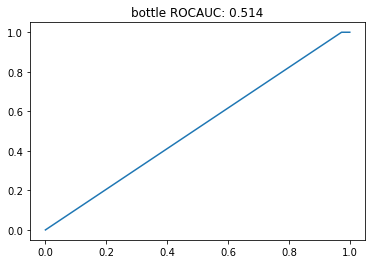

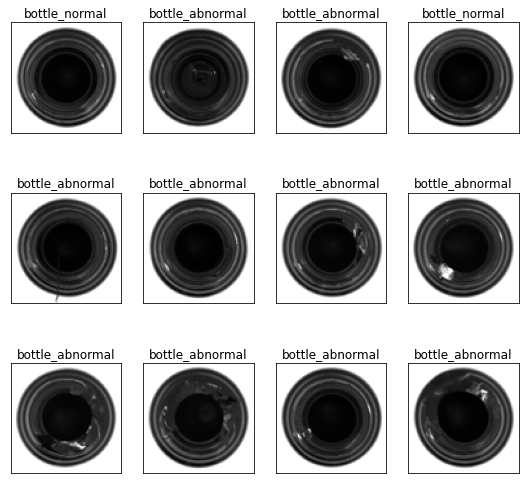

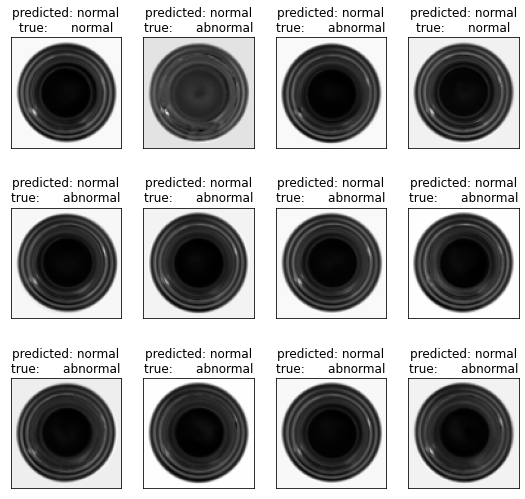

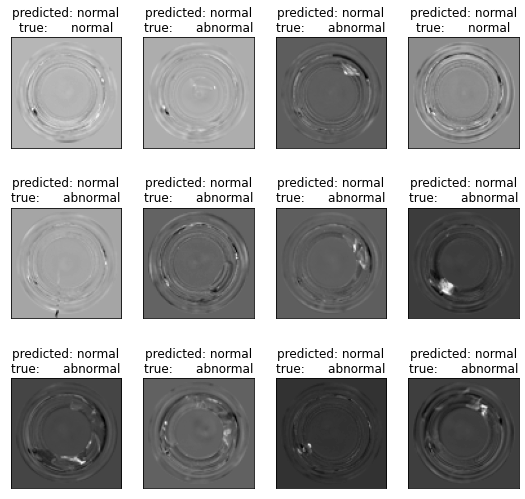

In [8]:
# -------------------------------------
# [Empty Module #1] Reconstruction based anomaly detection
# -------------------------------------
# 
# ------------------------------------------------------------
# 구현 가이드라인 
# ------------------------------------------------------------
# [1] train.imgs와 val.imgs 정규화.
# [2] PCA 초기화 및 train imgs를 학습
# Baseline : PCA(n_components=n_components), random_state=777
# [3] val imgs를 transform.
# [4] [3]로 얻은 val_pca를 inverse_transform을 통해 복원. scaler의 
# inverse_transform을 진행 후, (num_data_imgs, img_width, img_height)로 reshape.
# [5] Reconstruction_error = Original imgs - Reconstruction imgs
# Original imgs : reshape (num_data_imgs, img_width, img_height)를 해야합니다.
 # ------------------------------------------------------------

n_components = 0.8
    
# [1]
scaler = StandardScaler() #Scaler 선언
#sc = MinMaxScaler()

scaler.fit(train.imgs) #scaler fit
train_sc = scaler.transform(train.imgs) #scaler로 값 변환
val_sc = scaler.transform(val.imgs) #scaler로 값 변환

# [2]
# pca = 
# pca.fit()
pca = PCA(n_components = n_components, random_state = 777) #PCA 선언
pca.fit(train_sc) #pca 학습
# [3] val_pca = pca.transform(정규화된 val.imgs)
val_pca = pca.transform(val_sc) #pca로 차원 축소
# [4] Reconstruction imgs = 
# hint. pca.inverse_transform()
# hint. scaler.inverse_transform()
# hint. reshape [num_of_img, width, height] 
inverse_pca_val = pca.inverse_transform(val_pca) #역변환
inverse_sc_val = scaler.inverse_transform(inverse_pca_val) #역변환
Reconstruction_imgs = inverse_sc_val.reshape(val['imgs'].shape[0], 86, 86) #이미지 형태로 구조 변환
# [5] 
# 변수명
# ori = Original imgs ~ reshape [n_sample, w, h]
# Reconstruction imgs

# Reconstruction_error = Original imgs - Reconstruction_imgs
ori = val.imgs.reshape(val['imgs'].shape[0], 86, 86) #이미지 형태로 구조 변환
Reconstruction_error = ori - Reconstruction_imgs #에러 구하기
#____________________
# score & predict normal/abnormal
min_max_scaler = MinMaxScaler()

cls_score = Reconstruction_error.sum(axis=1).sum(axis=1)
cls_score = min_max_scaler.fit_transform(cls_score.reshape(-1, 1))

y_pred = cls_score

th = 0.5
y_pred[cls_score < th] = -1
y_pred[cls_score > th] = 1
y_pred = y_pred.reshape(-1)

#____________________
# metric. ROC_AUC
gt_list = np.asarray(val.labels)
fpr, tpr, _ = roc_curve(gt_list, cls_score)
img_roc_auc = roc_auc_score(gt_list, cls_score)

plt.plot(fpr, tpr, label='%s ROCAUC: %.3f' % (cls, img_roc_auc))
plt.title(f'{cls} ROCAUC: {img_roc_auc:.3f}')

print(f'{cls} ROCAUC: {img_roc_auc:.3f}')

#____________________
# Visualize
# original
target_names = {-1:'abnormal', 1:'normal'}
orginal_title = [f'{cls}_{target_names[label]}' for label in gt_list]
plot_gallery(ori, orginal_title, size[0], size[1])


prediction_titles = [title(y_pred, gt_list, target_names, i)
                     for i in range(y_pred.shape[0])]
# Reconstruction img                     
plot_gallery(Reconstruction_imgs, prediction_titles, size[0], size[1])
# Reconstruction error img                     
plot_gallery(Reconstruction_error, prediction_titles, size[0], size[1])


plt.show()
#____________________


Average ROCAUC: 0.744


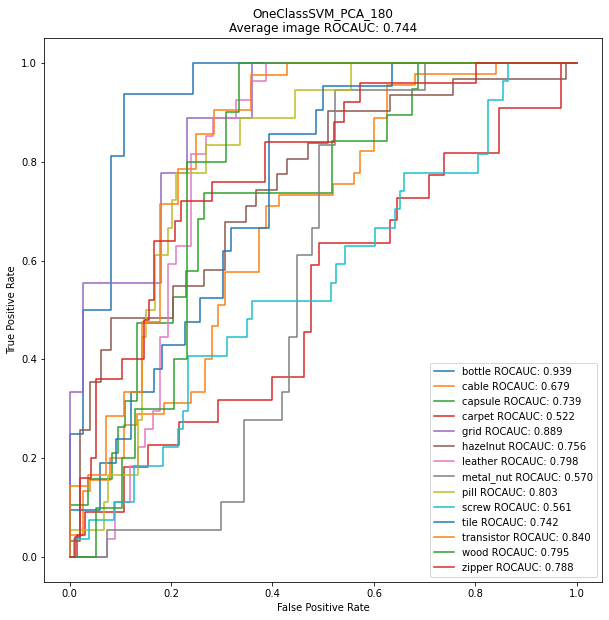

In [16]:
DB_PATH = "MVTecAD"

OUT_PATH = './'
FIG_PATH = join(OUT_PATH, "fig")
if os.path.isdir(FIG_PATH)!=True:
    os.mkdir(FIG_PATH)

# -------------------------------------
# [Empty Module #2]
# -------------------------------------
# ------------------------------------------------------------
# 구현 가이드라인 
# ------------------------------------------------------------
# Empty Module
# [0] classification module과 pca 모델 초기화
#  사용된 PCA. e.g. PCA, RandomizePCA, KernelPCA...
# Baseline : sklearn.svm.OneClassSVM, kernel="rbf", gamma=0.001, nu=0.01
# Baseline : PCA(n_components=n_components), random_state=777
# RandomizePCA ~(svd_solver='randomized') 사용시, whiten=True로 사용.
# [1] train.imgs와 val.imgs 정규화.
# [2] PCA 초기화와 정규화된 train.imgs를 학습 후, 정규화된 train.imgs, val imgs를 transform.
# [3] OneClassSVM을 이용하여 차원 축소된 train 학습 후 val data 추론. 
# hint. OneClassSVM.predict, OneClassSVM.score_samples 사용.
# [4] test.imgs에 [1]~[3]과 동일한 과정을 적용. 단, 추론 시 score에 대해서만 계산

from sklearn.svm import OneClassSVM

dataset = MVTec_AD(DB_PATH, OUT_PATH, flatten=True, size=size)

n_components=180
size = (86, 86)

y_preds = []
y_test = []

roc_auc = dict()
total_roc_auc = []

plt.figure(figsize=[10, 10])
# print(f'\n=====clf:{clf_name}, DA:{dr_name}=====')
# total_roc_auc = []

pbar = tqdm(dataset.class_names)

sample_submit = pd.read_csv('sample_submit.csv', index_col=0)
i=0
for cls in pbar:

    train = dataset.read_mvtec(cls=cls, mode='train')
    val = dataset.read_mvtec(cls=cls, mode='val')
    test = dataset.read_mvtec(cls=cls, mode='test')
    
    # [0]
    clf = OneClassSVM(kernel = 'rbf', gamma=0.001, nu = 0.01) #classifier 선언
    pca = PCA(n_components = n_components, svd_solver = 'randomized', whiten = True) #PCA 내부 sovler 선언 후 whiten = True 설정
    
    # [1]
    train_sc = scaler.fit_transform(train.imgs) #sclaer 적용
    val_sc = scaler.transform(val.imgs)
    # [2]
    train_pca = pca.fit_transform(train_sc) #pca 적용
    val_pca = pca.transform(val_sc)
    ## val
    # [3]
    # 변수명
    # y_pred : clf.predict
    # cls_score_val : clf.score_samples
    clf.fit(train_pca) #학습
    y_pred = clf.predict(val_pca) #예측
    cls_score_val = clf.score_samples(val_pca)

    
    ## test
    #[4]
    # 변수명
    # cls_score : clf.score_samples
    test_sc = scaler.transform(test.imgs) #스케일러
    test_pca = pca.transform(test_sc) #PCA
    cls_score = clf.score_samples(test_pca) #예측
    #####################
    # eval~valid data
    y_preds.append(y_pred)
    gt_list = np.array(val.labels)
    fpr, tpr, _ = roc_curve(gt_list, cls_score_val)
    img_roc_auc = roc_auc_score(gt_list, cls_score_val)
    total_roc_auc.append(img_roc_auc)
    plt.plot(fpr, tpr, label='%s ROCAUC: %.3f' % (cls, img_roc_auc))


    #=======================================================================
    
    sample_submit['score'][i:i+cls_score.shape[0]] = scaler.fit_transform(cls_score.reshape(-1,1)).reshape(-1)
    i = i+cls_score.shape[0]
    #=======================================================================

print('Average ROCAUC: %.3f' % np.mean(total_roc_auc))
clf_name = type(clf).__name__
pca_name = type(pca).__name__
plt.title(f'{clf_name}_{pca_name}_{n_components}\nAverage image ROCAUC: {np.mean(total_roc_auc):.3f}' )

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Result Figure
plt.savefig(f'{FIG_PATH}/{clf_name}_{pca_name}_{n_components}.jpg')

# Submit CSV
sample_submit.to_csv(f'./{clf_name}_{pca_name}_{n_components}.csv')

In [17]:
test = dataset.read_mvtec(cls=cls, mode='test')
np.sqrt(test.imgs.shape[1])

86.0